In [94]:
# Imports - install the packages you need yourself where you want them

import sys
import os

from dataclasses import dataclass

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold


from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from catboost import CatBoostClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# So ANN's work with sklearn
#from scikeras.wrappers import KerasClassifier
from xgboost import XGBClassifier


In [95]:
TARGET = "lead"
RANDOM_SEED = 42

train_df = pd.read_csv(r'C:/Users/rules/OneDrive/Desktop/pipes/PreliminaryDCdataset.csv') # Dataframe for your train set

def get_X_and_y(train_df, TARGET):
    print(train_df.columns.to_list())
    return train_df.drop(TARGET, axis=1), train_df[TARGET]

def clean_column_names(X):
    df = X.copy()
    df.columns = [col.split('_', 1)[-1].strip('_') for col in df.columns]
    return df

def feature_adder(X):
    df = X.copy()
    numerical_df = pd.DataFrame()

    # Add features here (i.e. numerical_df['new_feature'] = numerical_df['old_feature'] ** 2)
    
    standard_scaler = StandardScaler().set_output(transform='pandas')
    numerical_df_standard = standard_scaler.fit_transform(numerical_df)

    df = pd.concat([df, numerical_df_standard], axis=1)

    return df

def label_encode(s):
    le = LabelEncoder()
    return le.fit_transform(s)

def add_noise_feature(X):
    df = X.copy()
    random_noise = np.random.normal(loc=0, scale=1, size=X.shape[0])
    df['Noise'] = random_noise
    return df

In [96]:
train_df['bed'] = train_df['bed'].fillna(-1)
train_df['PrivateSymbol'] = train_df['PrivateSymbol'].replace({'Lead': 1, 'NonLead': 0})
train_df.columns = ['pricing','bed','bath','sqft','plot_size','address','PublicSymbol','lead']


In [97]:
train_df.info()

train_df['pricing'] = train_df['pricing'].str.replace(',', '').str.replace('$', '').astype(int)
train_df.loc[train_df['bed'] == 'Studio', 'bed'] = 1
train_df['bed'] = train_df['bed'].astype(int)
train_df['pricing'] = train_df['pricing'].astype(int)
train_df['bath'] = train_df['bath'].str.replace('+', '').astype(float)
train_df['sqft'] = train_df['sqft'].str.replace(',', '')
train_df['plot_size'] = train_df['plot_size'].str.replace(',', '').astype(float)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pricing       1151 non-null   object
 1   bed           1151 non-null   object
 2   bath          1048 non-null   object
 3   sqft          1139 non-null   object
 4   plot_size     1138 non-null   object
 5   address       1151 non-null   object
 6   PublicSymbol  1151 non-null   object
 7   lead          1151 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 72.1+ KB


In [98]:
train_df['sqft'] = train_df['sqft'].fillna(-1)
train_df['sqft'] = train_df['sqft'].str.replace(',', '').astype(float)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pricing       1151 non-null   int32  
 1   bed           1151 non-null   int32  
 2   bath          1048 non-null   float64
 3   sqft          1139 non-null   float64
 4   plot_size     1138 non-null   float64
 5   address       1151 non-null   object 
 6   PublicSymbol  1151 non-null   object 
 7   lead          1151 non-null   int64  
dtypes: float64(3), int32(2), int64(1), object(2)
memory usage: 63.1+ KB


In [99]:
# Set output type for all transformers to pandas dataframe
set_config(transform_output="pandas")

class DataTransformer:
    def __init__(self, add_features=True, target_name=TARGET, remove_cols=[], num_imputer='None', scaling='None', cat_encoding='None'):
        self.target_name = target_name
        self.remove_cols = remove_cols
        self.feature_list = train_df.drop(target_name, axis=1).drop(remove_cols, axis=1).columns.tolist()
        self.num_imputer = num_imputer
        self.scaling = scaling
        self.cat_encoding = cat_encoding
        self.add_features = add_features

    def __str__(self): 
        return f"\
            Removed columns: {self.remove_cols}\n\
            Numerical Imputer: {self.num_imputer}\n\
            Numerical Scaler: {self.scaling}\n\
            Categorical_Encoder: {self.cat_encoding}\
            "

    def establish_pipeline(self):
        '''
        Establishes a data transformation pipeline using the columns of the train data csv,
        without the specified columns from [remove_cols]
        '''
        # Lists for names of numerical and categorical columns in X
        categorical_cols = []
        categorical_cols = [col for col in categorical_cols if col not in self.remove_cols]

        numerical_cols = [col for col in self.feature_list if col not in categorical_cols]
        [col for col in numerical_cols if col not in self.remove_cols]

        num_pipe = Pipeline(
            steps=[
            ]
        )

        if self.num_imputer == 'mean':
            num_pipe.steps.append(('Mean Imputer', SimpleImputer()))

        elif self.num_imputer == 'iterative':
            num_pipe.steps.append(('Iterative Imputer', IterativeImputer()))

        if self.scaling == 'standard':
            num_pipe.steps.append(('Standard Scaler', StandardScaler()))
        elif self.scaling == 'minmax':
            num_pipe.steps.append(('MinMax Scaler', MinMaxScaler()))

        cat_pipe = Pipeline(
            steps=[]
        )

        if self.cat_encoding == 'ohe':
            cat_pipe.steps.append(('One Hot Encoder', OneHotEncoder(drop='if_binary', sparse_output=False)))


        preprocessor = ColumnTransformer(
            transformers=[
                ('Numerical', num_pipe, numerical_cols),
                ('Categorical', cat_pipe, categorical_cols),
            ]
        )

        return preprocessor

In [100]:
@dataclass
class ModelDeployerConfig:
    """
    Configuration class for the ModelDeployer.
    """
    
    train_df = train_df

    X, y = get_X_and_y(train_df, TARGET)

    transformer = DataTransformer(
        remove_cols=["PublicSymbol", "address"], # Columns to remove
        target_name = TARGET, # Dependent column name
        num_imputer='iterative', # Type of imputer for numerical features
        scaling='standard', # Type of numerical scaling
        cat_encoding='ohe', # Type of categorical encoding
        add_features=False, # Add custom features
    )

    preprocessor = transformer.establish_pipeline()

    models = {
        'CatBoost' : CatBoostClassifier(verbose=False, random_state=RANDOM_SEED),
        # 'DecisionTree' : DecisionTreeClassifier(random_state=RANDOM_SEED),
        'XGBoost' : XGBClassifier(objective='binary:logistic', tree_method='hist', enable_categorical=True, random_state=RANDOM_SEED),
        # 'Adaboost' : AdaBoostClassifier(n_estimators=75, learning_rate=0.75, random_state=RANDOM_SEED),
        'RandomForest' : RandomForestClassifier(random_state=RANDOM_SEED),
        # 'KNN': KNeighborsClassifier(),
        # 'ANN' : KerasClassifier(build_fn=specific_nn_generator(len(transformer.feature_list), len(np.unique(y))), epochs=5, batch_size=32)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True)


class ModelDeployer:
    """
    A class for deploying and evaluating machine learning models.
    """
    def __init__(self):
        self.config = ModelDeployerConfig()

    def cv_models(self):
        """
        Perform cross-validation for different machine learning models.

        :return: Dictionary containing model names and their cross-validation scores.
        """
        model_cv_scores = {}

        predict_pipeline = Pipeline(steps=[
                ('Preprocessor', self.config.preprocessor),
                ('Fix Names', FunctionTransformer(clean_column_names))
            ])
        
        # if self.config.transformer.add_features:
        #     predict_pipeline.steps.append(('Add Features', FunctionTransformer(feature_adder)))

        for model_name, model in self.config.models.items():
            predict_pipeline.steps.append((model_name, model))
            if model_name == 'XGBoost' or model_name == 'CatBoost':
                label_encoder = LabelEncoder().fit(self.config.y)
                y_encoded = label_encoder.transform(self.config.y)
                cv_results = cross_validate(predict_pipeline, self.config.X, y_encoded, cv=self.config.cv, scoring='roc_auc')
            elif model_name == 'ANN':
                cv_results = cross_validate(predict_pipeline, self.config.X, self.config.y, cv=self.config.cv, scoring='accuracy')
            else:
                cv_results = cross_validate(predict_pipeline, self.config.X, self.config.y, cv=self.config.cv, scoring='roc_auc')
            model_cv_scores[model_name] = cv_results['test_score']

            predict_pipeline.steps.pop(-1)
        
        return model_cv_scores

    def plot_model_mean_performance(self):
        """
        Plot the mean performance of different machine learning models.
        """
        model_scores = self.cv_models()
        model_names = model_scores.keys()
        cv_scores = model_scores.values()
        avg_scores = [np.mean(scores) for scores in cv_scores]

        plt.figure(figsize=(20, 15))

        model_hist = sns.barplot(x=list(model_names), y=avg_scores)

        model_hist.set_xticklabels(model_hist.get_xticklabels(), rotation=45)

        plt.show()
    
    def plot_feature_importance(self, model_name, display=True, ax=None, add_noise=False):
        """
        Plot feature importance for a specific model.

        :param model_name: The name of the model.
        :param display: Whether to display the plot.
        :param ax: The axis to use for plotting.
        :param add_noise: Whether to add noise to the data.
        :return: The feature importance plot.
        """
        model = self.config.models[model_name]
        predict_pipeline = Pipeline(steps=[
            ('Preprocessor', self.config.preprocessor),
            ('Fix Names', FunctionTransformer(clean_column_names))
            ])
        
        # if self.config.transformer.add_features:
        #     predict_pipeline.steps.append(('Add Features', FunctionTransformer(feature_adder)))

        if add_noise:
            predict_pipeline.steps.append(('Add Noise', FunctionTransformer(add_noise_feature)))

        predict_pipeline.steps.append((model_name, model))

        y = label_encode(self.config.y)

        predict_pipeline.fit(self.config.X, y)
        
        if model_name == 'XGBoost':
            features = model.get_booster().feature_names
            importances = model.feature_importances_
        elif model_name == 'CatBoost':
            features = model.feature_names_
            importances = model.get_feature_importance()
        else:
            features = model.feature_names_in_
            importances = model.feature_importances_
        
        sorted_idx = importances.argsort()

        features = np.array(features)
        importances = np.array(importances)

        fi = sns.barplot(x=features[sorted_idx], y=importances[sorted_idx], ax=ax)
        fi.set_xticklabels(fi.get_xticklabels(), rotation=90, fontsize=6)
        fi.bar_label(fi.containers[0], rotation=270, fontsize=7)


        if display: 
            plt.show()

        return fi
    
    def plot_all_model_importances(self, add_noise=False, save_figure=False):
        """
        Plot feature importance for all models.

        :param add_noise: Whether to add noise to the data.
        :param save_figure: Whether to save the figure.
        :return: The feature importance plots.
        """
        model_names = list(self.config.models.keys())
        try:
            model_names.remove('ANN')
            model_names.remove('KNN')
        except:
            pass

        fig, axs = plt.subplots(1, len(list(model_names)), figsize=(20, 15))
        for i, model_name in enumerate(model_names):
            fi_plot = self.plot_feature_importance(model_name, display=False, ax=axs[i], add_noise=add_noise)
            fi_plot.set_title(model_name)

        plt.tight_layout()
        plt.show()

model_deployer = ModelDeployer()


['pricing', 'bed', 'bath', 'sqft', 'plot_size', 'address', 'PublicSymbol', 'lead']


C:\Users\rules\AppData\Local\Temp\ipykernel_6888\3301957988.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  model_hist.set_xticklabels(model_hist.get_xticklabels(), rotation=45)


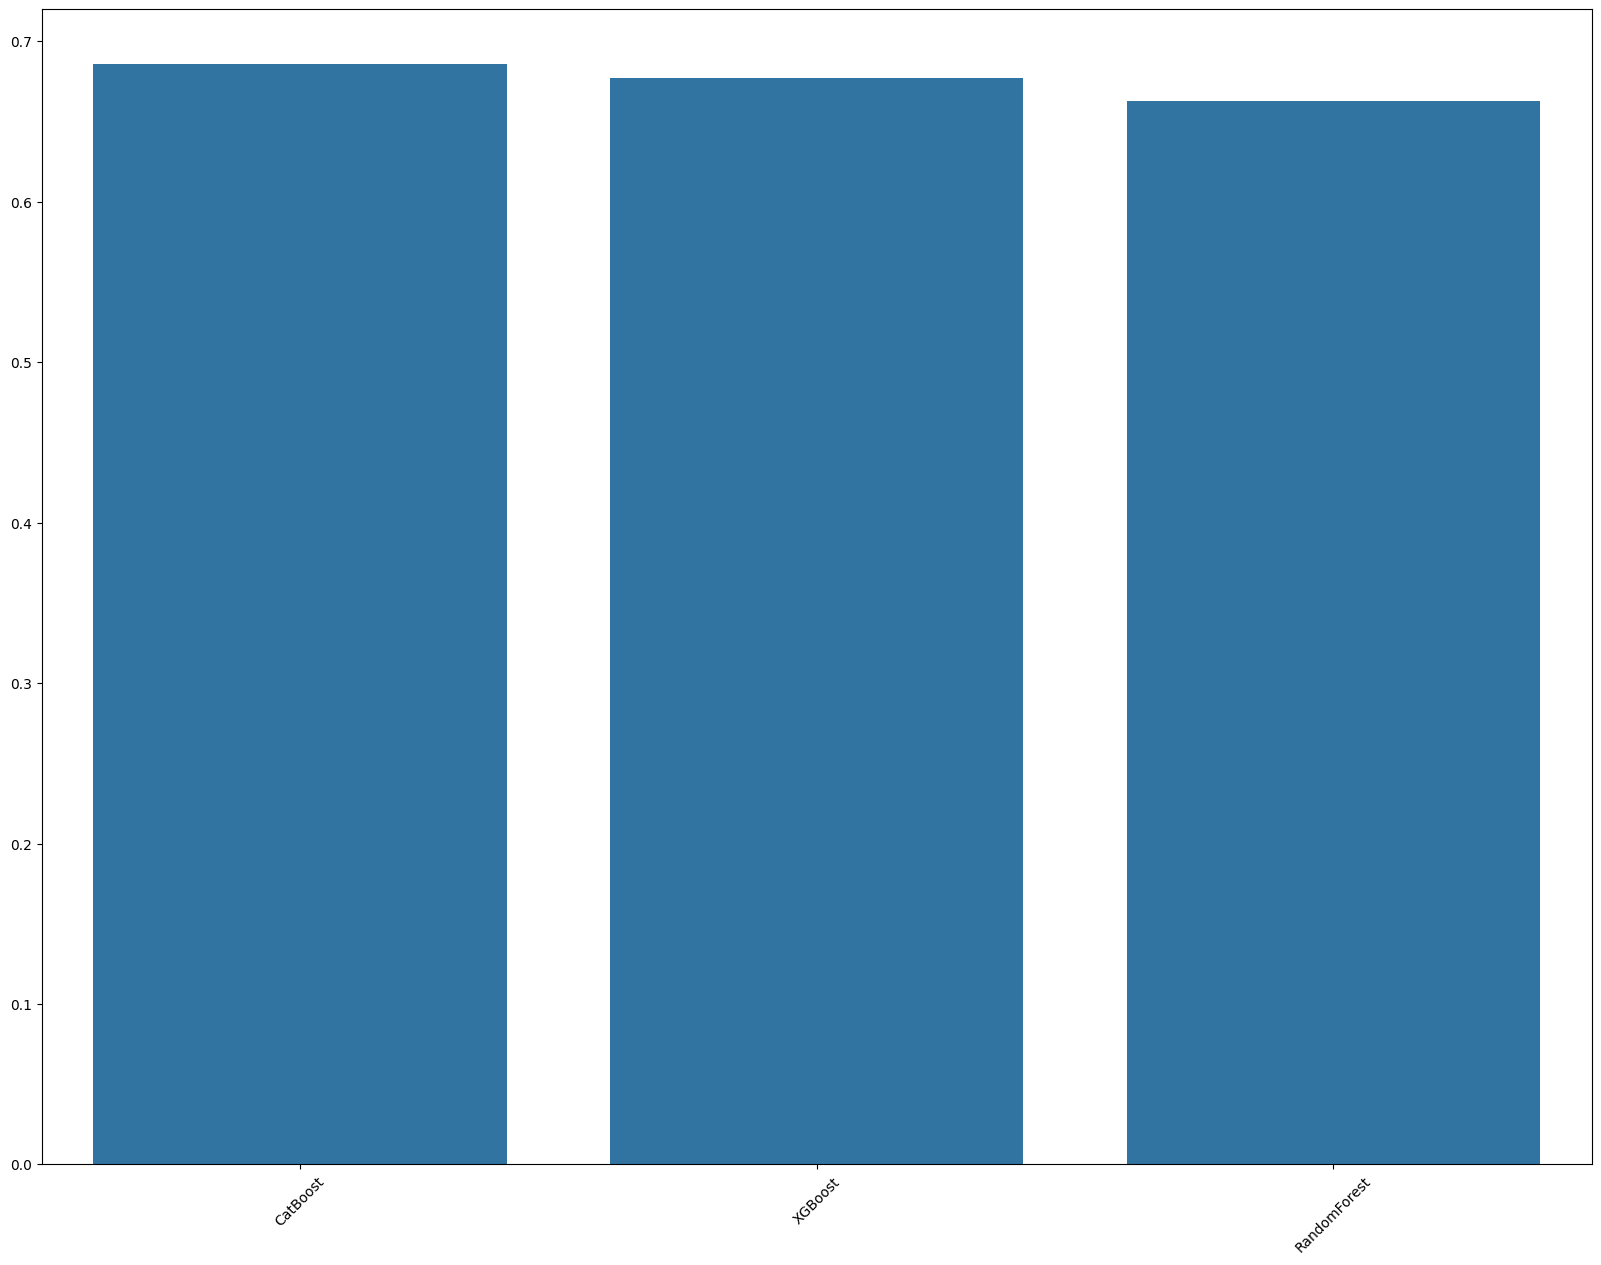

In [101]:
model_deployer.plot_model_mean_performance()

0.21285838401390095